In [1]:
import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt
%matplotlib inline
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
train_data = np.load("train_blob_data.npy",allow_pickle=True)

test_data = np.load("test_blob_data.npy",allow_pickle=True)

In [3]:
mosaic_list_of_images = train_data[0]["mosaic_list"]
mosaic_label = train_data[0]["mosaic_label"]
fore_idx = train_data[0]["fore_idx"]


test_mosaic_list_of_images = test_data[0]["mosaic_list"]
test_mosaic_label = test_data[0]["mosaic_label"]
test_fore_idx = test_data[0]["fore_idx"]

In [4]:
class MosaicDataset1(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list, mosaic_label,fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list
    self.label = mosaic_label
    self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] , self.fore_idx[idx]

In [5]:
batch = 250
train_dataset = MosaicDataset1(mosaic_list_of_images, mosaic_label, fore_idx)
train_loader = DataLoader( train_dataset,batch_size= batch ,shuffle=False)
test_dataset = MosaicDataset1(test_mosaic_list_of_images, test_mosaic_label, test_fore_idx)
test_loader = DataLoader(test_dataset,batch_size= batch ,shuffle=False)

In [6]:
bg = []
for i in range(12):
  torch.manual_seed(i)
  betag = torch.randn(250,9)#torch.ones((250,9))/9
  bg.append( betag.requires_grad_() )

In [7]:
bg

[tensor([[-1.1258, -1.1524, -0.2506,  ..., -0.3160, -2.1152,  0.3223],
         [-1.2633,  0.3500,  0.3081,  ..., -0.2473, -1.3527, -1.6959],
         [ 0.5667,  0.7935,  0.5988,  ...,  0.7502, -0.5855, -0.1734],
         ...,
         [ 0.8374, -0.7942, -0.3622,  ...,  0.0121,  0.8032, -0.6962],
         [-1.0645,  0.2384, -0.3385,  ...,  0.9635, -1.0340,  0.1894],
         [ 0.8253,  1.1038, -1.2491,  ..., -0.5940, -1.7125,  0.3617]],
        requires_grad=True),
 tensor([[-1.5256, -0.7502, -0.6540,  ..., -0.9798, -1.6091, -0.7121],
         [ 0.3037, -0.7773, -0.2515,  ...,  0.4676, -0.6970, -1.1608],
         [ 0.6995,  0.1991,  0.8657,  ...,  1.1017, -0.1759, -2.2456],
         ...,
         [-0.4302,  0.1508,  0.6937,  ...,  0.0314,  2.6645,  0.1189],
         [ 1.4484, -0.0213, -1.3367,  ...,  0.6279, -1.4719, -1.0291],
         [ 0.9081, -1.2433,  1.6062,  ..., -0.1177, -0.5548, -0.0595]],
        requires_grad=True),
 tensor([[-1.0408,  0.9166, -1.3042,  ..., -1.0574, -0.1188,

In [8]:
class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    self.linear1 = nn.Linear(5,100)
    self.linear2 = nn.Linear(100,3)

  def forward(self,x):
    x = F.relu(self.linear1(x))
    x = self.linear2(x)
    return x

In [9]:
torch.manual_seed(1234)
what_net = Module2().double()

what_net.load_state_dict(torch.load("blob_what_net.pt"))
what_net = what_net.to("cuda")

In [10]:
def attn_avg(x,beta):
  y = torch.zeros([batch,5], dtype=torch.float64)
  y = y.to("cuda")
  alpha = F.softmax(beta,dim=1)   # alphas
  #print(alpha[0],x[0,:])
  for i in range(9):            
    alpha1 = alpha[:,i]      
    y = y + torch.mul(alpha1[:,None],x[:,i])
  return y,alpha


In [11]:
def calculate_attn_loss(dataloader,what,criter):
  what.eval()
  r_loss = 0
  alphas = []
  lbls = []
  pred = []
  fidices = []
  correct = 0
  tot = 0
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels,fidx= data
      lbls.append(labels)
      fidices.append(fidx)
      inputs = inputs.double()
      beta = bg[i]  # beta for ith batch
      inputs, labels,beta = inputs.to("cuda"),labels.to("cuda"),beta.to("cuda")
      avg,alpha = attn_avg(inputs,beta)
      alpha = alpha.to("cuda")
      outputs = what(avg)
      _, predicted = torch.max(outputs.data, 1)
      correct += sum(predicted == labels)
      tot += len(predicted)
      pred.append(predicted.cpu().numpy())
      alphas.append(alpha.cpu().numpy())
      loss = criter(outputs, labels)
      r_loss += loss.item()
  alphas = np.concatenate(alphas,axis=0)
  pred = np.concatenate(pred,axis=0)
  lbls = np.concatenate(lbls,axis=0)
  fidices = np.concatenate(fidices,axis=0)
  #print(alphas.shape,pred.shape,lbls.shape,fidices.shape) 
  analysis = analyse_data(alphas,lbls,pred,fidices)
  return r_loss/i,analysis,correct.item(),tot,correct.item()/tot

In [12]:
# for param in what_net.parameters():
#     param.requires_grad = False

In [13]:

def analyse_data(alphas,lbls,predicted,f_idx):
    '''
       analysis data is created here
    '''
    batch = len(predicted)
    amth,alth,ftpt,ffpt,ftpf,ffpf = 0,0,0,0,0,0
    for j in range (batch):
      focus = np.argmax(alphas[j])
      if(alphas[j][focus] >= 0.5):
        amth +=1
      else:
        alth +=1
      if(focus == f_idx[j] and predicted[j] == lbls[j]):
        ftpt += 1
      elif(focus != f_idx[j] and predicted[j] == lbls[j]):
        ffpt +=1
      elif(focus == f_idx[j] and predicted[j] != lbls[j]):
        ftpf +=1
      elif(focus != f_idx[j] and predicted[j] != lbls[j]):
        ffpf +=1
    #print(sum(predicted==lbls),ftpt+ffpt)
    return [ftpt,ffpt,ftpf,ffpf,amth,alth]

In [14]:
optim1 = []
for i in range(12):
  optim1.append(optim.RMSprop([bg[i]], lr=1))

In [15]:
# instantiate optimizer
optimizer_what = optim.RMSprop(what_net.parameters(), lr=0.001)#, momentum=0.9)#,nesterov=True)


 


criterion = nn.CrossEntropyLoss()
acti = []
analysis_data_tr = []
analysis_data_tst = []
loss_curi_tr = []
loss_curi_tst = []
epochs = 200


# calculate zeroth epoch loss and FTPT values
running_loss,anlys_data,correct,total,accuracy = calculate_attn_loss(train_loader,what_net,criterion)
print('training epoch: [%d ] loss: %.3f correct: %.3f, total: %.3f, accuracy: %.3f' %(0,running_loss,correct,total,accuracy)) 
loss_curi_tr.append(running_loss)
analysis_data_tr.append(anlys_data)




# training starts 
for epoch in range(epochs): # loop over the dataset multiple times
  ep_lossi = []
  running_loss = 0.0
  what_net.train()
  for i, data in enumerate(train_loader, 0):
    # get the inputs
    inputs, labels,_  = data
    inputs = inputs.double()
    beta = bg[i] # alpha for ith batch
    #print(labels)
    inputs, labels,beta = inputs.to("cuda"),labels.to("cuda"),beta.to("cuda")
        
    # zero the parameter gradients
    optimizer_what.zero_grad()
    optim1[i].zero_grad()
      
    # forward + backward + optimize
    avg,alpha = attn_avg(inputs,beta)
    outputs = what_net(avg)     
    loss = criterion(outputs, labels)

    # print statistics
    running_loss += loss.item()
    #alpha.retain_grad()
    loss.backward(retain_graph=False)
    optimizer_what.step()
    optim1[i].step()


  running_loss_tr,anls_data,correct,total,accuracy = calculate_attn_loss(train_loader,what_net,criterion)
  analysis_data_tr.append(anls_data)
  loss_curi_tr.append(running_loss_tr)   #loss per epoch
  print('training epoch: [%d ] loss: %.3f correct: %.3f, total: %.3f, accuracy: %.3f' %(epoch+1,running_loss_tr,correct,total,accuracy)) 


  
  if running_loss_tr<=0.08:
    break
print('Finished Training run ')
analysis_data_tr = np.array(analysis_data_tr)



training epoch: [0 ] loss: 12.050 correct: 1071.000, total: 3000.000, accuracy: 0.357
training epoch: [1 ] loss: 2.314 correct: 1864.000, total: 3000.000, accuracy: 0.621
training epoch: [2 ] loss: 1.086 correct: 2445.000, total: 3000.000, accuracy: 0.815
training epoch: [3 ] loss: 0.666 correct: 2616.000, total: 3000.000, accuracy: 0.872
training epoch: [4 ] loss: 0.530 correct: 2659.000, total: 3000.000, accuracy: 0.886
training epoch: [5 ] loss: 0.459 correct: 2696.000, total: 3000.000, accuracy: 0.899
training epoch: [6 ] loss: 0.399 correct: 2708.000, total: 3000.000, accuracy: 0.903
training epoch: [7 ] loss: 0.370 correct: 2721.000, total: 3000.000, accuracy: 0.907
training epoch: [8 ] loss: 0.341 correct: 2727.000, total: 3000.000, accuracy: 0.909
training epoch: [9 ] loss: 0.329 correct: 2728.000, total: 3000.000, accuracy: 0.909
training epoch: [10 ] loss: 0.326 correct: 2730.000, total: 3000.000, accuracy: 0.910
training epoch: [11 ] loss: 0.319 correct: 2738.000, total: 300

In [16]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_train[columns[0]] = np.arange(0,epoch+2)
df_train[columns[1]] = analysis_data_tr[:,-2]
df_train[columns[2]] = analysis_data_tr[:,-1]
df_train[columns[3]] = analysis_data_tr[:,0]
df_train[columns[4]] = analysis_data_tr[:,1]
df_train[columns[5]] = analysis_data_tr[:,2]
df_train[columns[6]] = analysis_data_tr[:,3]

In [17]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,302,2698,135,936,179,1750
1,1,1264,1736,283,1581,172,964
2,2,2239,761,561,1884,44,511
3,3,2366,634,662,1954,28,356
4,4,2405,595,706,1953,27,314
...,...,...,...,...,...,...,...
196,196,2686,314,876,1910,6,208
197,197,2691,309,877,1915,6,202
198,198,2690,310,878,1908,6,208
199,199,2690,310,877,1917,6,200


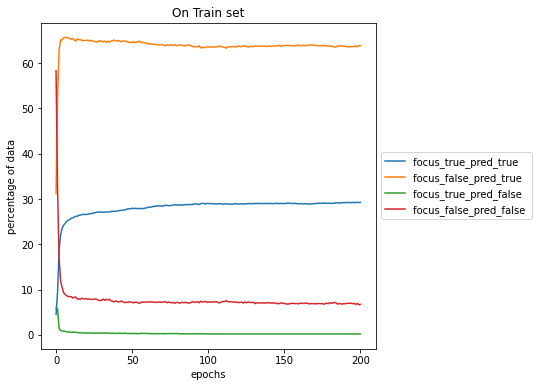

In [18]:
fig= plt.figure(figsize=(6,6))
plt.plot(df_train[columns[0]],df_train[columns[3]]/30, label ="focus_true_pred_true ")
plt.plot(df_train[columns[0]],df_train[columns[4]]/30, label ="focus_false_pred_true ")
plt.plot(df_train[columns[0]],df_train[columns[5]]/30, label ="focus_true_pred_false ")
plt.plot(df_train[columns[0]],df_train[columns[6]]/30, label ="focus_false_pred_false ")
plt.title("On Train set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("percentage of data")
plt.xticks([0,50,100,150,200])
#plt.vlines(vline_list,min(min(df_train[columns[3]]/300),min(df_train[columns[4]]/300),min(df_train[columns[5]]/300),min(df_train[columns[6]]/300)), max(max(df_train[columns[3]]/300),max(df_train[columns[4]]/300),max(df_train[columns[5]]/300),max(df_train[columns[6]]/300)),linestyles='dotted')
plt.show()
fig.savefig("train_analysis.pdf")
fig.savefig("train_analysis.png")

In [19]:
aph = []
for i in bg:
  aph.append(F.softmax(i,dim=1).detach().numpy())
  
aph = np.concatenate(aph,axis=0)
torch.save({
            'epoch': 500,
            'model_state_dict': what_net.state_dict(),
            #'optimizer_state_dict': optimizer_what.state_dict(),
            "optimizer_alpha":optim1,
            "FTPT_analysis":analysis_data_tr,
            "alpha":aph

            }, "type4_what_net_500.pt")

In [20]:
aph[0]

array([1.32141507e-08, 1.35936725e-05, 1.47228696e-09, 3.02196739e-17,
       1.08838513e-16, 5.69787717e-10, 3.41521898e-17, 5.62035477e-18,
       9.99986410e-01], dtype=float32)